In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
# inverted index
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# Build dataset 

block_size = 3 # context length: number of previous characters to consider for predicting next one

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for c in w + '.':
            i = stoi[c]
            X.append(context)
            Y.append(i)
            # print(''.join(itos[i] for i in context), '--->', itos[i])
            context = context[1:] + [i]
    return torch.tensor(X), torch.tensor(Y)


import random
random.seed(42)
random.shuffle(words)

n1, n2 = int(0.8 * len(words)), int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

print("total dataset size:", len(words))
print(f"data split training {len(Xtr)} dev {len(Xdev)} test {len(Xte)}")    


total dataset size: 32033
data split training 182625 dev 22655 test 22866


In [6]:
n_embed = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
# uniform or normal distribution
randfn = torch.rand
# we are representing each character by two values
# this is alternative to the one hot encoding which wont scale well for large vocabularies and context lengths
C = randfn((27, n_embed), generator=g, requires_grad=True)
# layer 1
W1 = randfn((block_size * n_embed, n_hidden), generator=g, requires_grad=True)
b1 = randfn((n_hidden,), generator=g, requires_grad=True)
# layer 2: output layer
W2 = randfn((n_hidden, 27), generator=g, requires_grad=True)
b2 = randfn((27,), generator=g, requires_grad=True)
parameters = [C, W1, b1, W2, b2]
print(" num parameters:", sum(p.numel() for p in parameters))


 num parameters: 11897


In [7]:
lossi = []

In [8]:
max_steps = 200000
batch_size = 32

# forward pass
for i in range(max_steps):
    # mini batch
    ix = torch.randint(0, len(Xtr), (batch_size,), generator=g)
    Yb, Xb = Ytr[ix], Xtr[ix]

    # get embeddings
    emb = C[Xb] # (:, block_size, embedding_size)
    embcat = emb.view(-1, block_size * n_embed)
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer post-activation
    # output layer
    logits = h @ W2 + b2 # (:, 27)
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad

    # track states
    if i % 1000 == 0:
        print(f'{i:05d}/{max_steps:05d} loss: {loss.item():.4f}')
    lossi.append(loss.log10().item())  


00000/200000 loss: 6.6536
01000/200000 loss: 3.4718
02000/200000 loss: 5.0823
03000/200000 loss: 3.6532
04000/200000 loss: 4.3359
05000/200000 loss: 4.2897
06000/200000 loss: 4.2131
07000/200000 loss: 4.9124
08000/200000 loss: 3.7614
09000/200000 loss: 4.1778
10000/200000 loss: 3.3153
11000/200000 loss: 3.9061
12000/200000 loss: 3.7081
13000/200000 loss: 3.5926
14000/200000 loss: 3.8411
15000/200000 loss: 3.2437
16000/200000 loss: 3.6039
17000/200000 loss: 4.9591
18000/200000 loss: 3.6108
19000/200000 loss: 3.4144
20000/200000 loss: 3.7241
21000/200000 loss: 4.0230
22000/200000 loss: 3.4668
23000/200000 loss: 3.9385
24000/200000 loss: 3.9236
25000/200000 loss: 3.1289
26000/200000 loss: 3.7550
27000/200000 loss: 3.0520
28000/200000 loss: 3.7590
29000/200000 loss: 4.1030
30000/200000 loss: 3.0194
31000/200000 loss: 2.8101
32000/200000 loss: 2.9571
33000/200000 loss: 2.6272
34000/200000 loss: 2.7172
35000/200000 loss: 2.9186
36000/200000 loss: 2.3211
37000/200000 loss: 2.3098
38000/200000

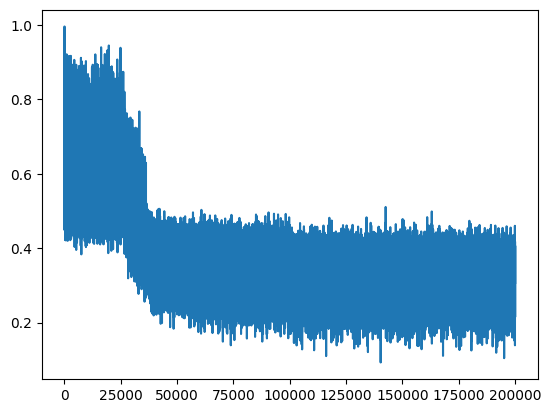

In [9]:
plt.plot(range(0, len(lossi)), lossi)

In [16]:
#calculate loss
@torch.no_grad() 
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(f"{split:10} loss: ", loss.item())

split_loss('train')
split_loss('val')

train      loss:  2.0738866329193115
val        loss:  2.119619607925415


In [17]:
g = torch.Generator().manual_seed(2147483647 + 10)# sample from the model 

def sample():
    out = []
    context = [0] * block_size
    name = ''
    while True:
        emb = C[torch.tensor(context)].view(1, -1)
        h = torch.tanh(emb @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        if ix == 0:
            break
        out.append(ix)
    return ''.join(itos[i] for i in out)

for _ in range(10):
    print(sample())


carmah
amelle
khy
mili
taty
salaysie
mahnen
deliah
jarqui
nellara
